# Кодирование смысла

In [1]:
!pip install keras-preprocessing gensim scikit-learn matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from keras_preprocessing.text import Tokenizer
import re
from matplotlib.patches import Patch
import gensim.downloader as api

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
class SimpleBagOfWords:
    def __init__(self):
        self.word2index: dict[str, int] = {}
        self.index2word: dict[int, str] = {}

    def preprocess_text(self, text: str):
        return " ".join(map(lambda word: re.sub(r"\W*", "", word).lower(), text.split()))

    def fit(self, texts: list[str]):
        for text in texts:
            for word in self.preprocess_text(text).split():
                self.index2word[self.word2index.setdefault(word, len(self.word2index))] = word

        return self

    def transform(self, texts: list[str]) -> np.ndarray:
        vectors: list[list[int]] = []
        for text in texts:
            vector = [0] * len(self.word2index)
            for word in self.preprocess_text(text).split():
                vector[self.word2index[word]] += 1
            vectors.append(vector)

        return np.array(vectors)

    def fit_transform(self, texts: list[str]) -> np.ndarray:
        return self.fit(texts).transform(texts)

    def get_feature_names(self):
        return list(self.word2index.keys())

## Ограничения bow

### Одинаковые слова, разный смысл

In [4]:
bow_model = SimpleBagOfWords()
sentences = [
    "Он совсем не умный",
    "Он не совсем умный"
]

vectors = bow_model.fit_transform(sentences)

print("Словарь:", bow_model.get_feature_names())
print("Размер словаря:", len(bow_model.word2index))
print("Векторы BoW:")
for i, text in enumerate(sentences):
    print(f"{text:<20}': {vectors[i]}")

print(np.array_equal(vectors[0], vectors[1]))

Словарь: ['он', 'совсем', 'не', 'умный']
Размер словаря: 4
Векторы BoW:
Он совсем не умный  ': [1 1 1 1]
Он не совсем умный  ': [1 1 1 1]
True


### Одинаковые слова, разный контекст

In [5]:
bow_model = SimpleBagOfWords()
sentences = [
    "хороший фильм, но плохой сценарий",  # противопоставление
    "плохой фильм, но хороший сценарий",  # противопоставление
    "очень хороший фильм и хороший сценарий",  # положительный отзыв
    "очень плохой фильм и плохой сценарий"   # отрицательный отзыв
]

vectors = bow_model.fit_transform(sentences)

print("Словарь:", bow_model.get_feature_names())
print("Размер словаря:", len(bow_model.word2index))
print("Векторы BoW:")
for i, text in enumerate(sentences):
    print(f"{text:<20}': {vectors[i]}")

print(np.array_equal(vectors[0], vectors[1]))

Словарь: ['хороший', 'фильм', 'но', 'плохой', 'сценарий', 'очень', 'и']
Размер словаря: 7
Векторы BoW:
хороший фильм, но плохой сценарий': [1 1 1 1 1 0 0]
плохой фильм, но хороший сценарий': [1 1 1 1 1 0 0]
очень хороший фильм и хороший сценарий': [2 1 0 0 1 1 1]
очень плохой фильм и плохой сценарий': [0 1 0 2 1 1 1]
True


In [19]:
def visualize_bow_vectors(texts: list[str], vectors, title="Визуализация BoW-векторов"):
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    colors = ['red', 'red', 'blue', 'blue', 'green', 'green']

    for i, (text, color) in enumerate(zip(texts, colors)):
        x, y = vectors_2d[i]
        plt.scatter(x, y, color=color, s=100, alpha=0.7, edgecolors='black')
        short_text = text[:20] + '...' if len(text) > 20 else text
        plt.annotate(short_text, (x, y), xytext=(5, 5),
                    textcoords='offset points', fontsize=9)

    plt.xlabel('Компонента PCA 1')
    plt.ylabel('Компонента PCA 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)

    legend_elements = [
        Patch(facecolor='red', label='Укусы'),
        Patch(facecolor='blue', label='Лук'),
        Patch(facecolor='green', label='Фильмы')
    ]
    plt.legend(handles=legend_elements)

    plt.show()

    # Выводим объяснение PCA
    print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
    print(f"Суммарная объясненная дисперсия: {sum(pca.explained_variance_ratio_):.3f}")

In [20]:
bow_model = SimpleBagOfWords()
test_texts = [
    "собака укусила человека",
    "человек укусил собаку",
    "стреляю из лука",
    "плачу от лука",
    "люблю смотреть фильмы",
    "фильмы смотреть люблю"
]
vectors = bow_model.fit_transform(test_texts)


print("Словарь:", bow_model.get_feature_names())
print("Размер словаря:", len(bow_model.word2index))
print("Векторы BoW:")
for i, text in enumerate(test_texts):
    print(f"{text:<25}': {vectors[i]}")

Словарь: ['собака', 'укусила', 'человека', 'человек', 'укусил', 'собаку', 'стреляю', 'из', 'лука', 'плачу', 'от', 'люблю', 'смотреть', 'фильмы']
Размер словаря: 14
Векторы BoW:
собака укусила человека  ': [1 1 1 0 0 0 0 0 0 0 0 0 0 0]
человек укусил собаку    ': [0 0 0 1 1 1 0 0 0 0 0 0 0 0]
стреляю из лука          ': [0 0 0 0 0 0 1 1 1 0 0 0 0 0]
плачу от лука            ': [0 0 0 0 0 0 0 0 1 1 1 0 0 0]
люблю смотреть фильмы    ': [0 0 0 0 0 0 0 0 0 0 0 1 1 1]
фильмы смотреть люблю    ': [0 0 0 0 0 0 0 0 0 0 0 1 1 1]


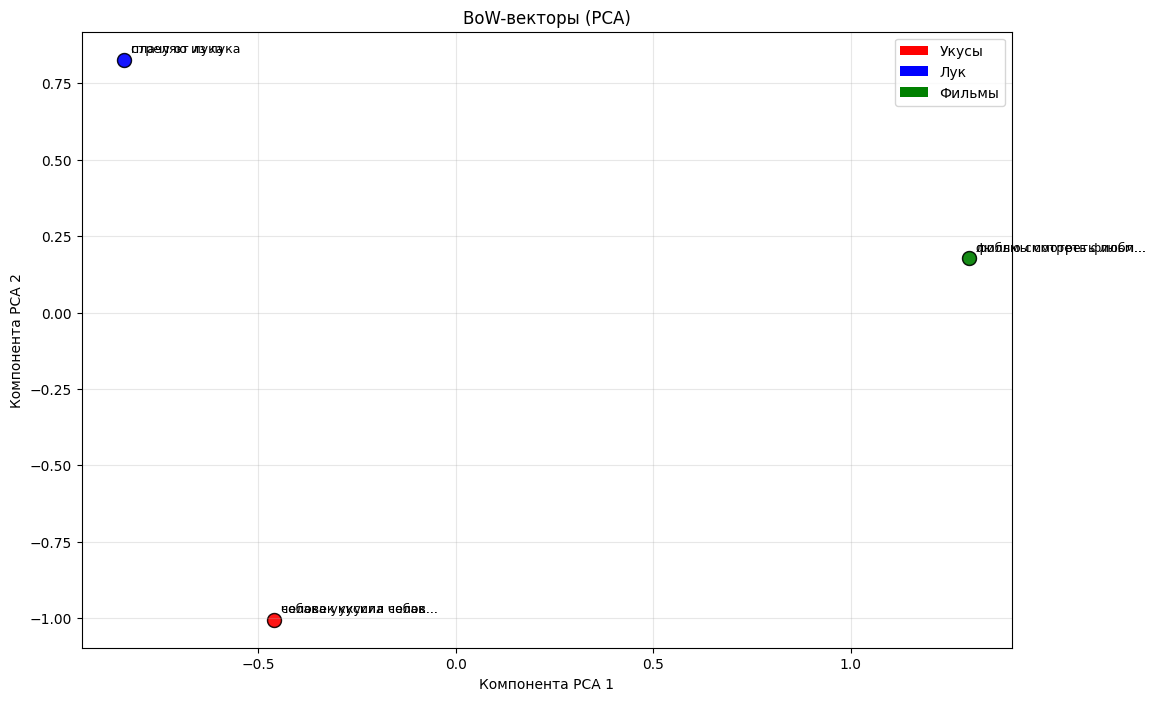

Объясненная дисперсия: [0.38160369 0.25254265]
Суммарная объясненная дисперсия: 0.634


In [21]:
visualize_bow_vectors(test_texts, vectors, "BoW-векторы (PCA)")

## Word2Vec



In [9]:
word2vec_model = api.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


In [10]:
def demonstrate_vector_arithmetic_with_tags(model):
    examples = [
        (['король_NOUN', 'женщина_NOUN'], ['мужчина_NOUN'], 'королева_NOUN'),
        (['отец_NOUN', 'дочь_NOUN'], ['сын_NOUN'], 'мать_NOUN'),
        (['врач_NOUN', 'мужчина_NOUN'], ['женщина_NOUN'], 'врач_NOUN'),
        (['учитель_NOUN', 'женщина_NOUN'], ['мужчина_NOUN'], 'учительница_NOUN'),

        (['большой_ADJ', 'хороший_ADJ'], ['маленький_ADJ'], 'плохой_ADJ'),
        (['горячий_ADJ', 'быстрый_ADJ'], ['холодный_ADJ'], 'медленный_ADJ'),

        (['бежать_VERB', 'стоять_VERB'], ['стоять_VERB'], 'бежать_VERB'),
        (['говорить_VERB', 'слушать_VERB'], ['молчать_VERB'], 'слышать_VERB'),

        (['день_NOUN', 'ночь_NOUN'], ['ночь_NOUN'], 'день_NOUN'),
        (['лето_NOUN', 'зима_NOUN'], ['зима_NOUN'], 'лето_NOUN'),
        (['верх_NOUN', 'низ_NOUN'], ['низ_NOUN'], 'верх_NOUN')
    ]

    for pos, neg, expected in examples:
      try:
          missing_words = [word for word in pos + neg if word not in model.key_to_index]
          if missing_words:
              print(f"❌ Пропущенные слова в модели: {missing_words}")
              continue

          result = model.most_similar(positive=pos, negative=neg, topn=5)

          print(f"\n🔍 Аналогия: {pos} - {neg} = ?")
          print(f"   Ожидается: '{expected}'")
          print("   Топ-5 результатов:")
          for i, (word, score) in enumerate(result, 1):
              match_indicator = " ✅" if word == expected else ""
              print(f"   {i}. {word} (сходство: {score:.4f}){match_indicator}")

          # Проверим, есть ли ожидаемое слово в результатах
          result_words = [word for word, score in result]
          if expected in result_words:
              rank = result_words.index(expected) + 1
              print(f"   🎯 Ожидаемое слово найдено на позиции {rank}")
          else:
              print(f"   ⚠️ Ожидаемое слово '{expected}' не в топ-5")

      except Exception as e:
          print(f"❌ Ошибка для {pos} - {neg}: {e}")

In [11]:
demonstrate_vector_arithmetic_with_tags(word2vec_model)


🔍 Аналогия: ['король_NOUN', 'женщина_NOUN'] - ['мужчина_NOUN'] = ?
   Ожидается: 'королева_NOUN'
   Топ-5 результатов:
   1. королева_NOUN (сходство: 0.7314) ✅
   2. герцог_NOUN (сходство: 0.6502)
   3. принцесса_NOUN (сходство: 0.6266)
   4. герцогиня_NOUN (сходство: 0.6240)
   5. королевство_NOUN (сходство: 0.6094)
   🎯 Ожидаемое слово найдено на позиции 1

🔍 Аналогия: ['отец_NOUN', 'дочь_NOUN'] - ['сын_NOUN'] = ?
   Ожидается: 'мать_NOUN'
   Топ-5 результатов:
   1. мать_NOUN (сходство: 0.7160) ✅
   2. сестра_NOUN (сходство: 0.6659)
   3. тетка_NOUN (сходство: 0.6522)
   4. жена_NOUN (сходство: 0.6504)
   5. племянница_NOUN (сходство: 0.6450)
   🎯 Ожидаемое слово найдено на позиции 1

🔍 Аналогия: ['врач_NOUN', 'мужчина_NOUN'] - ['женщина_NOUN'] = ?
   Ожидается: 'врач_NOUN'
   Топ-5 результатов:
   1. медик_NOUN (сходство: 0.7043)
   2. хирург_NOUN (сходство: 0.6448)
   3. терапевт_NOUN (сходство: 0.6232)
   4. пациент_NOUN (сходство: 0.6224)
   5. врачебный_ADJ (сходство: 0.6218)


In [12]:
def find_similar_words_with_tags(model, word, topn=8):
    print(f"Слова, близкие к '{word}'")
    try:
        if word not in model.key_to_index:
            print(f"❌ Слово '{word}' не найдено в модели")
            return

        similar_words = model.most_similar(word, topn=topn)
        print(f"🎯 Топ-{topn} наиболее похожих слов:")
        for i, (similar_word, similarity) in enumerate(similar_words, 1):
            word_parts = similar_word.split('_')
            if len(word_parts) > 1:
                display_word = f"{word_parts[0]}[{word_parts[1]}]"
            else:
                display_word = similar_word

            print(f"{i:2d}. {display_word:<25} (сходство: {similarity:.4f})")

    except Exception as e:
        print(f"❌ Ошибка при поиске похожих слов: {e}")

In [13]:
find_similar_words_with_tags(word2vec_model, 'человек_NOUN')
find_similar_words_with_tags(word2vec_model, 'говорить_VERB')
find_similar_words_with_tags(word2vec_model, 'большой_ADJ')
find_similar_words_with_tags(word2vec_model, 'хороший_ADJ')

Слова, близкие к 'человек_NOUN'
🎯 Топ-8 наиболее похожих слов:
 1. женщина[NOUN]             (сходство: 0.5500)
 2. мужчина[NOUN]             (сходство: 0.5161)
 3. человеческий[ADJ]         (сходство: 0.5005)
 4. идолопоклонствовать[VERB] (сходство: 0.4839)
 5. высокопорядочный[ADJ]     (сходство: 0.4819)
 6. правдознатец[NOUN]        (сходство: 0.4815)
 7. некорыстолюбивый[ADJ]     (сходство: 0.4799)
 8. народ[NOUN]               (сходство: 0.4772)
Слова, близкие к 'говорить_VERB'
🎯 Топ-8 наиболее похожих слов:
 1. сказать[VERB]             (сходство: 0.7461)
 2. заговаривать[VERB]        (сходство: 0.6289)
 3. разговаривать[VERB]       (сходство: 0.6110)
 4. думать[VERB]              (сходство: 0.5953)
 5. толковать[VERB]           (сходство: 0.5946)
 6. рассуждать[VERB]          (сходство: 0.5900)
 7. рассказывать[VERB]        (сходство: 0.5744)
 8. отвечать[VERB]            (сходство: 0.5691)
Слова, близкие к 'большой_ADJ'
🎯 Топ-8 наиболее похожих слов:
 1. огромный[ADJ]          

In [14]:
def visualize_word2vec_with_tags(model):
    word_groups = {
        'nouns_people': ['человек_NOUN', 'люди_NOUN', 'личность_NOUN', 'персона_NOUN'],
        'nouns_time': ['время_NOUN', 'год_NOUN', 'день_NOUN', 'месяц_NOUN'],
        'verbs_action': ['говорить_VERB', 'сказать_VERB', 'молчать_VERB', 'кричать_VERB'],
        'adjectives_size': ['большой_ADJ', 'маленький_ADJ', 'огромный_ADJ', 'крошечный_ADJ'],
        'adjectives_quality': ['хороший_ADJ', 'плохой_ADJ', 'отличный_ADJ'],
        'nouns_professions': ['врач_NOUN', 'учитель_NOUN', 'инженер_NOUN', 'программист_NOUN'],
        'verbs_movement': ['бежать_VERB', 'ходить_VERB', 'стоять_VERB', 'лежать_VERB'],
        'adjectives_emotions': ['счастливый_ADJ', 'грустный_ADJ', 'злой_ADJ', 'радостный_ADJ']
    }

    all_words = []
    all_vectors = []
    available_groups = {}

    for group_name, words in word_groups.items():
        available_words = []
        for word in words:
            if word in model.key_to_index:
                available_words.append(word)
                all_words.append(word)
                all_vectors.append(model[word])
            else:
                print(f"⚠️ Слово '{word}' не найдено в модели, пропускаем")

        if available_words:
            available_groups[group_name] = available_words

    if not all_vectors:
        print("❌ Не найдено ни одного слова из заданных групп в модели")
        return

    all_vectors_array = np.array(all_vectors)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(all_vectors_array)-1))
    vectors_2d = tsne.fit_transform(all_vectors_array)
    plt.figure(figsize=(16, 12))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

    color_map = {}
    for i, group_name in enumerate(available_groups.keys()):
        color_map[group_name] = colors[i % len(colors)]

    start_idx = 0
    for group_name, words in available_groups.items():
        end_idx = start_idx + len(words)
        group_vectors = vectors_2d[start_idx:end_idx]

        x = group_vectors[:, 0]
        y = group_vectors[:, 1]

        plt.scatter(x, y, c=color_map[group_name], s=100, alpha=0.7,
                   label=group_name, edgecolors='black', linewidth=0.5)

        for i, word in enumerate(words):
            clean_word = word.split('_')[0]
            plt.annotate(clean_word, (x[i], y[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, alpha=0.8,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor=color_map[group_name], alpha=0.2))

        start_idx = end_idx

    plt.title('Визуализация семантического пространства Word2Vec с тегами\n(t-SNE проекция)', fontsize=14, pad=20)
    plt.xlabel('t-SNE компонента 1')
    plt.ylabel('t-SNE компонента 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.figtext(0.02, 0.02, f"Всего слов: {len(all_words)} | Групп: {len(available_groups)}",
                fontsize=10, alpha=0.7)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Статистика визуализации:")
    print(f"   Всего слов визуализировано: {len(all_words)}")
    print(f"   Количество групп: {len(available_groups)}")
    for group_name, words in available_groups.items():
        print(f"   - {group_name}: {len(words)} слов")

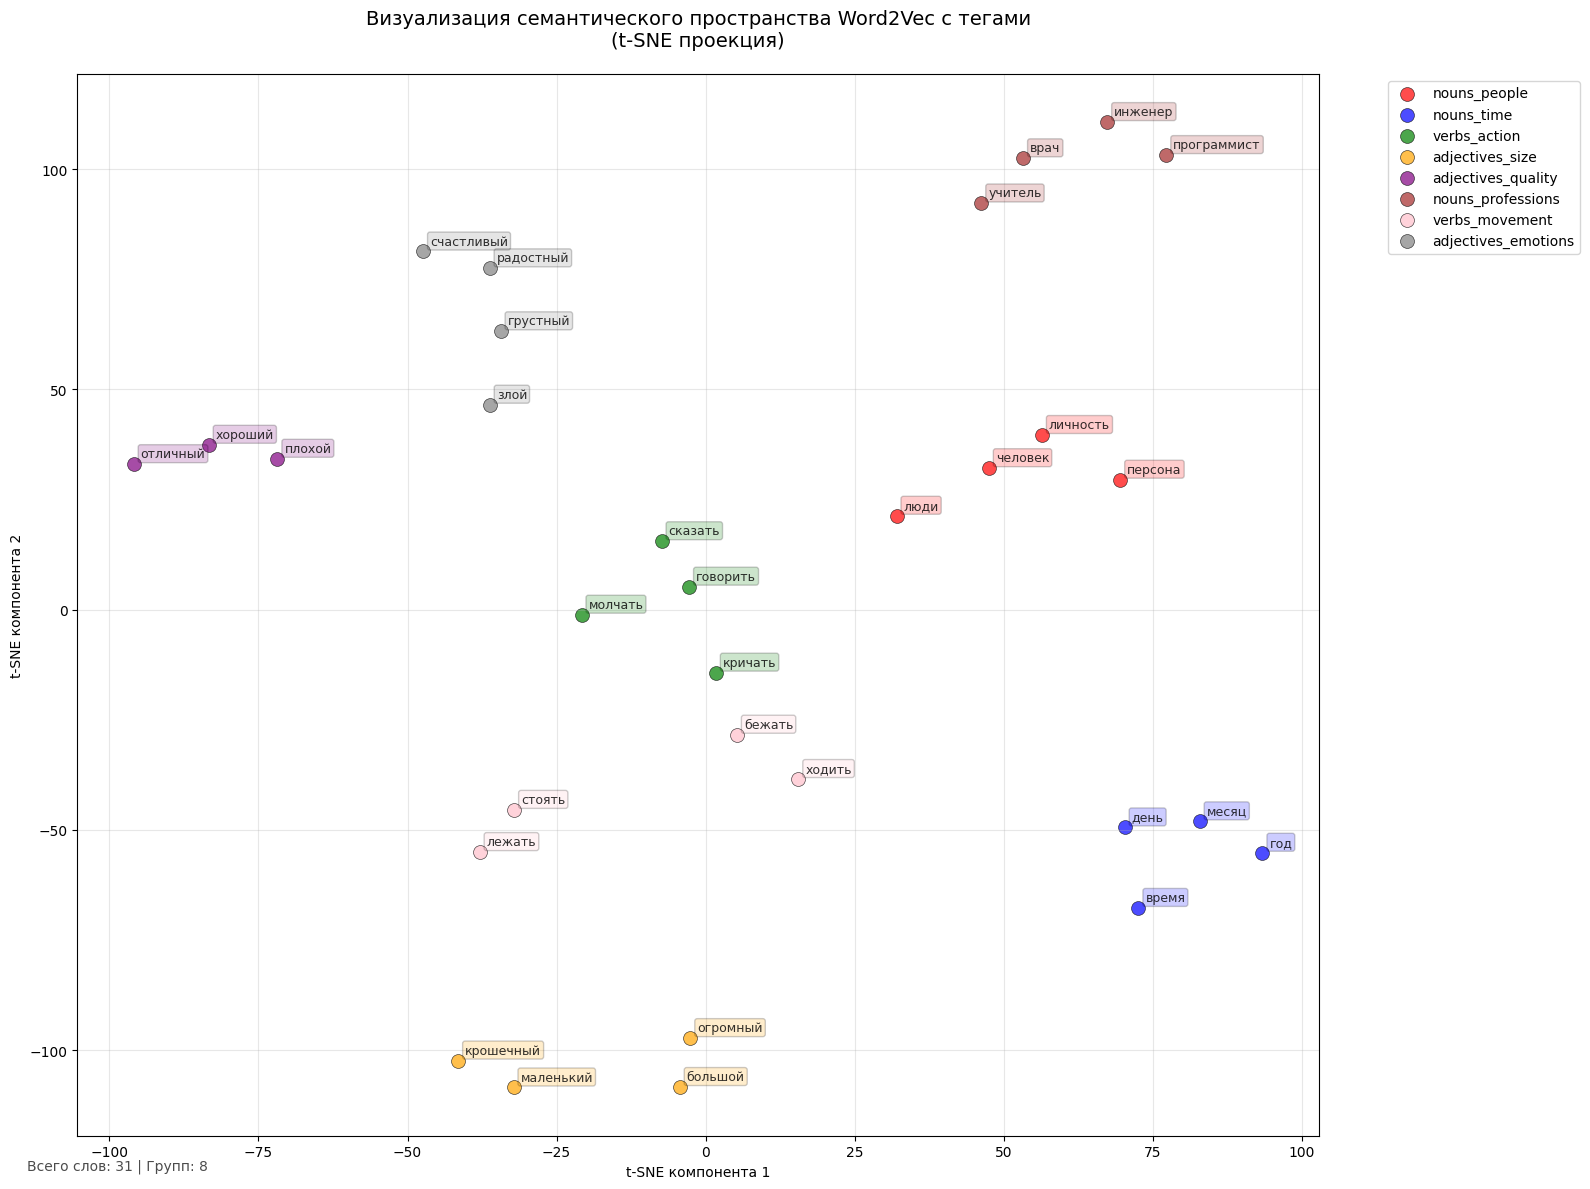


📊 Статистика визуализации:
   Всего слов визуализировано: 31
   Количество групп: 8
   - nouns_people: 4 слов
   - nouns_time: 4 слов
   - verbs_action: 4 слов
   - adjectives_size: 4 слов
   - adjectives_quality: 3 слов
   - nouns_professions: 4 слов
   - verbs_movement: 4 слов
   - adjectives_emotions: 4 слов


In [15]:
visualize_word2vec_with_tags(word2vec_model)

## Сравнение

### Bag of Words
Преимущества:
- Простота реализации
- Быстрота работы
- Хорошо работает для классификации - когда важна частота слов

Недостатки:
- Потеря порядка слов
- Потеря семантики - "умный" и "гениальный" считаются разными словами
- Разреженные векторы - много нулей, плохая эффективность памяти

### Word2Vec
Преимущества:
- Сохранение семантики
- Учет контекста - слова в похожих контекстах имеют близкие векторы
- Плотные векторы - эффективное использование памяти
- Понимает синонимы и родственные слова

Недостатки:
- Требует много данных для обучения качественных моделей
- Вычислительно сложнее чем BoW
- Проблемы с многозначностью - одно слово, разные значения